Before you begin, execute this cell to import numpy and packages from the D-Wave Ocean suite, and all necessary functions for the gate-model framework you are going to use, whether that is the Forest SDK or Qiskit. In the case of Forest SDK, it also starts the qvm and quilc servers.

In [0]:
%run -i "assignment_helper.py"
%matplotlib inline

Available frameworks:
Forest SDK
Qiskit
D-Wave Ocean


# Mapping clustering to discrete optimization

We will have $\{x_i\}_{i=1}^N$ points lying in two distant regions:

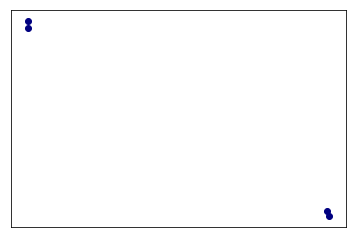

In [0]:
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

# Generating the data
c1 = np.random.rand(2, 2)/5
c2 = (-1.6, 1.5) + np.random.rand(2, 2)/5
data = np.concatenate((c1, c2))
plt.subplot(111, xticks=[], yticks=[])
plt.scatter(data[:, 0], data[:, 1], color='navy')

**Exercise 1** (3 points). The unsupervised task is identify this structure. The challenge is that if we have a high number of points compared to the number of qubits and their connections, we won't be able to solve the problem. So if we blindly follow the idea of mapping the problem to max-cut using the Eucledian distance and then solve it by some quantum optimization method, we would run out of qubit connections for this problem. We can, however, choose to be clever about how we calculate the distances classically. This is a common trick: since we are doing hybrid classical-quantum algorithms anyway, we might as well do the classical parts wisely.

In this case, we might rely on some form of [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis) to get a sense of the distances in the dataset. This is an easy case, since we just plotted the two-dimensional data, and we see that the density within a blob is high. You can make the task easier by thresholding the distances. Use any distance function you wish (even the Euclidean distance will do) and set distances to zero that are below a threshold you calculate. The threshold should be such that all of the distances within a blob will be set to zero. Store the symmetrix distance matrix in a two-dimensional numpy array called `w`.

In [0]:
import itertools

n_instances = data.shape[0]
###
### YOUR CODE HERE
###
w = np.zeros((n_instances, n_instances))
for i, j in itertools.product(*[range(n_instances)]*2):
    value = np.linalg.norm(data[i]-data[j])
    if value > 0.5:
        value = 1
    elif value <= 0.5:
        value = 0
    w[i, j] = value


In [0]:
labels = np.array([0, 0, 1, 1])
assert np.alltrue(w == w.T)
assert np.alltrue(w >= 0)
assert (w[labels==0][:, labels==0]==0).sum() == 4
assert (w[labels==1][:, labels==1]==0).sum() == 4

# Solving the max-cut problem by QAOA

**Exercise 2** (2 points). From here, it is rather formulaic to create the max-cut as an Ising Hamiltonian and solve either by annealing or by some variational circuit like QAOA. Set up the QAOA problem in your chosen framework and an optimization function. Import all necessary functions you need. Call the object `qaoa`. We set the `p` parameter of the QAOA to 1.

In [0]:
p = 1
###
### YOUR CODE HERE
###
from qiskit.aqua import get_aer_backend, QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.translators.ising import max_cut

qubit_operators, offset = max_cut.get_max_cut_qubitops(w)

optimizer = COBYLA()
qaoa = QAOA(qubit_operators, optimizer, p, operator_mode='matrix')

Setting $p=1$ in the QAOA algorithm, we can initialize it with the max-cut problem.

In [0]:
if isinstance(qaoa, qiskit.aqua.algorithms.adaptive.qaoa.qaoa.QAOA):
    assert qaoa._operator.num_qubits == 4
elif isinstance(qaoa, grove.pyqaoa.qaoa.QAOA):
    assert len(qaoa.ref_ham) == 4
    assert all([qaoa.ref_ham[i].terms[0].compact_str() == '(1+0j)*X{}'.format(i) for i in range(4)])
    assert len(qaoa.cost_ham) == 12
else:
    raise ValueError("Unknown type for Hamiltonian!")

**Exercise 3** (2 points). Run the QAOA on a simulator. Store the outcome in an object called `result`. In the case of the Forest SDK, this will store the return value of the `run_and_measure` method of the QVM. In the case of Qiskit, it will be the return value of the `run` method of the `qaoa` object.

In [0]:
###
### YOUR CODE HERE
###
backend = get_aer_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=1)
result = qaoa.run(quantum_instance)
x = max_cut.sample_most_likely(result['eigvecs'][0])
graph_solution = max_cut.get_graph_solution(x)
print('energy:', result['energy'])
print('maxcut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

energy: -0.9999999691675351
maxcut objective: -2.999999969167535
solution: [0. 0. 1. 1.]
solution objective: 4.0


In [0]:
ground_truth1 = [0, 0, 1, 1]
ground_truth2 = [1, 1, 0, 0]
if isinstance(result, list):
    count = np.unique(result, return_counts=True, axis=0)
    solution = count[0][np.argmax(count[1])]
    assert abs(sum(solution == ground_truth1)-4) <= 1 or abs(sum(solution == ground_truth2)-4) <= 1
else:
    x = max_cut.sample_most_likely(result['eigvecs'][0])
    solution = max_cut.get_graph_solution(x)
    assert abs(sum(solution == ground_truth1)-4) <= 1 or abs(sum(solution == ground_truth2)-4) <= 1